## Imports and creds

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

In [3]:
import numpy as np

In [4]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [5]:
# Mount drive - needed for GBQ creds
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_path = '/content/drive/MyDrive/GitHub'

In [7]:
credentials = service_account.Credentials.from_service_account_file(
    f'{root_path}/grav-waves/grav-waves-358320-34ebfeae2689.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [8]:
# This needs to be run to assign from BQ magic directly to pd df; otherwise, can use the string alternative
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [11]:
%load_ext rpy2.ipython

In [ ]:
%%R
# Libraries
install.packages("sysfonts")
install.packages("extrafont")
install.packages("showtext")
install.packages("bigrquery")
library(sysfonts)
library(extrafont)
library(showtext)
library(bigrquery)
library(tidyverse)
library(glue)

showtext_auto()
font_add_google("Inter", "int")

# Create a theme
theme_light_beige <- theme(plot.background = element_rect(fill = "#F0F1EA", color = "transparent"),
      panel.background = element_rect(fill = "#F0F1EA", color = "transparent"),
      plot.margin = margin(t = "1.5", r = "1.5", b = "1.5", l = "1.5", unit = "in"),
      plot.caption = element_text(size = 12, color = "#343A41", family = "int"),
      panel.grid = element_blank(),
      plot.title = element_text(size = 30, color = "#343A41", family = "int", face = "bold"),
      axis.text = element_text(size = 15, color = "#343A41", family = "int"),
      axis.title = element_text(size = 19, color = "#343A41", family = "int"),
      axis.ticks = element_blank(),
      legend.background = element_blank(),
      legend.position = "bottom",
      legend.title = element_text(color = "#343A41", family = "int"),
      legend.text = element_text(color = "#343A41", family = "int"),
      strip.background = element_rect(fill = "#343A41"),
      strip.text = element_text(color = "white", family = "int", face = "bold", size = 13))

## Pre-processing

1. The data is at the microsecond level which is way too much detail, so I'm going to sub-sample every deci-second.

In [9]:
%%bigquery --project grav-waves-358320 gw322_dsec

WITH dsec AS (SELECT id, observatory, CONCAT(DATE_TRUNC(capture_dttm, SECOND), ROUND(EXTRACT(MILLISECOND FROM capture_dttm)/100)) AS capture_dsec, MIN(capture_dttm) AS capture_dsec_tm
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1, 2, 3)

SELECT a.capture_dsec_tm, b.size
FROM dsec a
LEFT JOIN mergers.timeseries b
ON a.id = b.id
AND a.observatory = b.observatory
AND a.capture_dsec_tm = b.capture_dttm;

In [10]:
gw322_dsec.head()

,capture_dsec_tm,size
0,2020-03-22 09:11:18.300000,1.710048e-19
1,2020-03-22 09:11:18.350049,2.179845e-19
2,2020-03-22 09:11:18.450148,1.032926e-18
3,2020-03-22 09:11:18.550002,1.982664e-18
4,2020-03-22 09:11:18.650101,-4.560992e-19


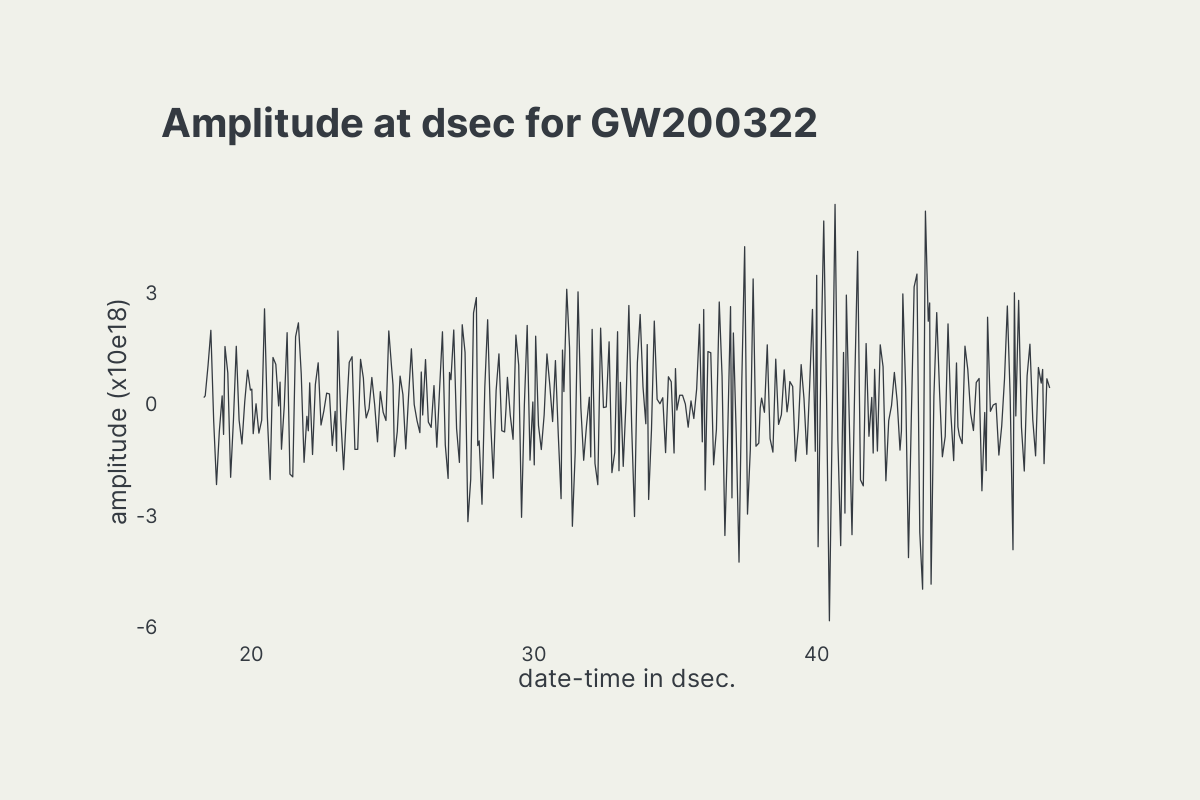

In [18]:
%%R -w 1200 -h 800 -i gw322_dsec

ggplot(gw322_dsec, aes(capture_dsec_tm, size*1e18)) +
geom_line(color = "#343A41", size = 0.6) +
labs(x = 'date-time in dsec.',
     y = 'amplitude (x10e18)',
     title = 'Amplitude at dsec for GW200322\n') +
theme_light_beige

Looks good. Let's lag it into percent change from previous deci-second.

In [24]:
%%bigquery --project grav-waves-358320 gw322_dsec_pc

WITH dsec AS (SELECT id, observatory, CONCAT(DATE_TRUNC(capture_dttm, SECOND), ROUND(EXTRACT(MILLISECOND FROM capture_dttm)/100)) AS capture_dsec, MIN(capture_dttm) AS capture_dsec_tm
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1, 2, 3)

SELECT a.capture_dsec_tm, (b.size - LAG(b.size) OVER(PARTITION BY a.id, a.observatory ORDER BY a.capture_dsec_tm)) / LAG(b.size) OVER(PARTITION BY a.id, a.observatory ORDER BY a.capture_dsec_tm) AS pc_ch
FROM dsec a
LEFT JOIN mergers.timeseries b
ON a.id = b.id
AND a.observatory = b.observatory
AND a.capture_dsec_tm = b.capture_dttm;

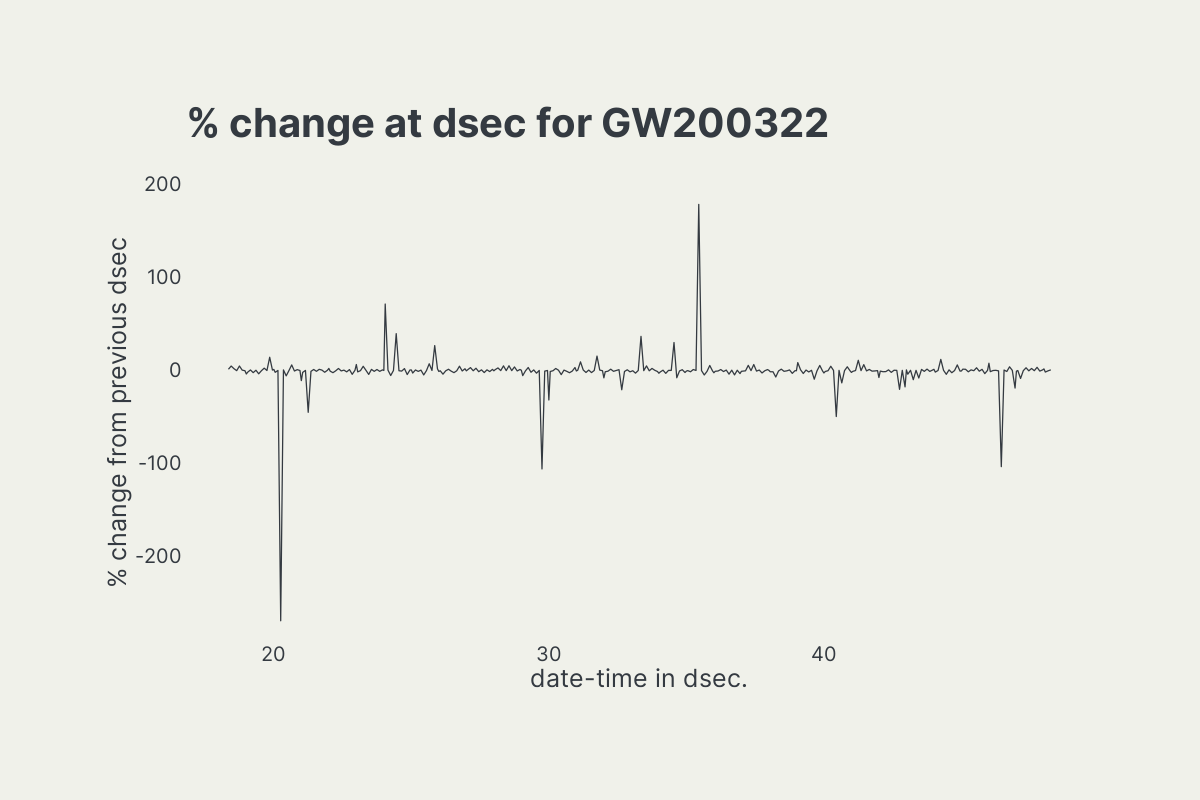

In [19]:
%%R -w 1200 -h 800 -i gw322_dsec_pc

ggplot(gw322_dsec_pc, aes(capture_dsec_tm, pc_ch)) +
geom_line(color = "#343A41", size = 0.6) +
labs(x = 'date-time in dsec.',
     y = '% change from previous dsec',
     title = '% change at dsec for GW200322\n') +
theme_light_beige

2. Split into train/test/val.

In [27]:
df = gw322_dsec[1:] # remove row with NA

In [46]:
timestamp_ds = df['capture_dsec_tm'].map(pd.Timestamp.timestamp)

In [50]:
type(timestamp_ds)

pandas.core.series.Series

In [51]:
df['sec_sin'] = np.sin(timestamp_s * (2 * np.pi))
df['sec_cos'] = np.cos(timestamp_s * (2 * np.pi))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
df_final = df[['size', 'sec_sin', 'sec_cos']]

For now, since I didn't limit the time after the event, we'll do a kind of odd train/test/val split to make sure the event is in the test space.

In [56]:
column_indices = {name: i for i, name in enumerate(df_final.columns)}

n = len(df_final)
train_df = df_final[0:int(n*0.4)]
val_df = df_final[int(n*0.6):int(n*0.9)]
test_df = df_final[int(n*0.9):]

num_features = df_final.shape[1]

In [57]:
num_features

3

In [58]:
train_df.head()

,size,sec_sin,sec_cos
1,0.180110,0.808836,-0.588034
2,0.825754,0.308131,-0.951344
3,1.578192,-0.309028,-0.951053
4,-0.353939,-0.809389,-0.587272
5,-1.713925,-0.999999,0.001250


3. Normalize the data

In [64]:
train_df.std()

size       1.000000
sec_sin    0.676737
sec_cos    0.735752
dtype: float64

In [44]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [59]:
train_df.mean(), train_df.std() # essentially, 0, 1 for training, perf!

(size       6.728624e-18
 sec_sin    7.770066e-05
 sec_cos    9.091836e-02
 dtype: float64, size       1.000000
 sec_sin    0.676737
 sec_cos    0.735752
 dtype: float64)

In [86]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

    plt.xlabel('Time [h]')

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [87]:
w2 = WindowGenerator(input_width = 6, label_width=1, shift=1, label_columns = ['size'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['size']

In [70]:
np.array(train_df[:w2.total_window_size]).shape

(110, 3)

In [72]:
np.array(train_df[100:100+w2.total_window_size]).shape

(32, 3)

In [78]:
np.array(train_df[44:44+w2.total_window_size]).shape

(88, 3)

In [75]:
len(train_df)/3

44.0

In [88]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[44:44+w2.total_window_size]),
                           np.array(train_df[88:88+w2.total_window_size])])

In [82]:
example_window.shape

TensorShape([3, 7, 3])

In [89]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[44:44+w2.total_window_size]),
                           np.array(train_df[88:88+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [90]:
w2.example = example_inputs, example_labels

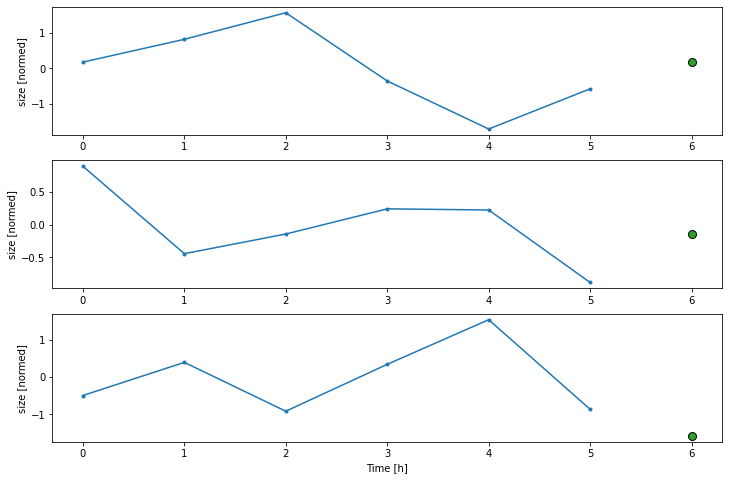

In [93]:
w2.plot(plot_col = 'size', max_subplots=5)

In [94]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [95]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [96]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [97]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [99]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['size'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['size']

In [100]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [101]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [103]:
baseline = Baseline(label_index=column_indices['size'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 5ms/step - loss: 7.5714 - mean_absolute_error: 2.2254


In [104]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['size'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['size']

In [105]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


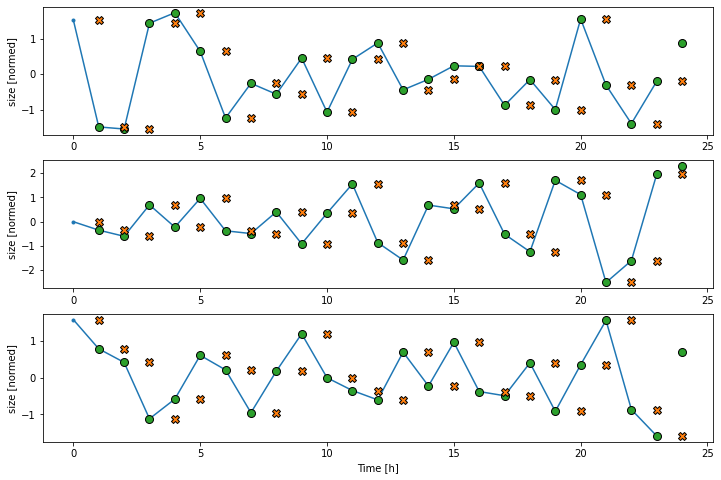

In [107]:
wide_window.plot(baseline, plot_col = 'size')

In [110]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [108]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [111]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
5/5 [==============================] - 1s 48ms/step - loss: 1.3070 - mean_absolute_error: 0.9199 - val_loss: 3.4336 - val_mean_absolute_error: 1.4384
Epoch 2/20
5/5 [==============================] - 0s 26ms/step - loss: 1.3018 - mean_absolute_error: 0.9177 - val_loss: 3.4290 - val_mean_absolute_error: 1.4374
Epoch 3/20
5/5 [==============================] - 0s 26ms/step - loss: 1.2963 - mean_absolute_error: 0.9157 - val_loss: 3.4242 - val_mean_absolute_error: 1.4363
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 1.2912 - mean_absolute_error: 0.9137 - val_loss: 3.4192 - val_mean_absolute_error: 1.4352
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 1.2865 - mean_absolute_error: 0.9118 - val_loss: 3.4147 - val_mean_absolute_error: 1.4342
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 1.2815 - mean_absolute_error: 0.9100 - val_loss: 3.4106 - val_mean_absolute_error: 1.4334
Epoch 7/20
5/5 [==================

In [112]:
performance

{'Baseline': [3.6400623321533203, 1.5150902271270752],
 'Linear': [1.648375153541565, 1.0258173942565918]}

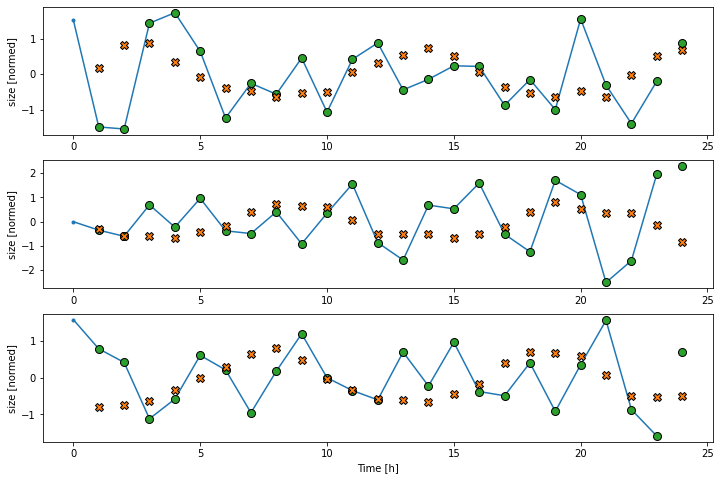

In [113]:
wide_window.plot(linear, plot_col = 'size')